In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from lightning import Trainer, seed_everything
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint, TQDMProgressBar
from func import Flickr8kDataset, CLIPDualEncoderModel, Config

seed_everything(42)

C:\Users\Kevin\miniconda3\envs\hehe\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 42


42

In [2]:
path = Path.home() / 'OneDrive - Seagroup/ai/image_captioning/flickr'
image_path = path / 'Images'

df = pd.read_csv(path / 'captions.txt')
df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
df['image_path'] = [str(image_path / i) for i in df['image'].to_numpy()]
df.head(7)

,image,caption,id,image_path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0,C:\Users\Kevin\OneDrive - Seagroup\ai\image_ca...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,0,C:\Users\Kevin\OneDrive - Seagroup\ai\image_ca...
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,0,C:\Users\Kevin\OneDrive - Seagroup\ai\image_ca...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,0,C:\Users\Kevin\OneDrive - Seagroup\ai\image_ca...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,0,C:\Users\Kevin\OneDrive - Seagroup\ai\image_ca...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting,1,C:\Users\Kevin\OneDrive - Seagroup\ai\image_ca...
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...,1,C:\Users\Kevin\OneDrive - Seagroup\ai\image_ca...


In [3]:
pretrain_model = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(pretrain_model)

In [4]:
train, test = train_test_split(df, test_size=.2, random_state=42)
train_dataset = Flickr8kDataset(train['image_path'].values.tolist(), train['caption'].values.tolist(),tokenizer=tokenizer)
test_dataset = Flickr8kDataset(test['image_path'].values.tolist(), test['caption'].values.tolist(),tokenizer=tokenizer)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [5]:
model = CLIPDualEncoderModel(Config.pretrain_image, Config.pretrain_text, batch_size=batch_size)
model_checkpoint = ModelCheckpoint(dirpath='clip/',
                                   save_top_k=1,
                                   monitor="val/loss",
                                   mode="min",)
lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = Trainer(
    accelerator='gpu',
    max_epochs=3,
    callbacks=[model_checkpoint, lr_monitor],
    deterministic=True,
)
trainer.fit(model,
            train_dataloaders=train_dataloader,
            val_dataloaders=test_dataloader)

Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ResNetModel: ['classifier.1.weight', 'classifier.1.bias']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with anoth

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Kevin\miniconda3\envs\hehe\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Kevin\miniconda3\envs\hehe\lib\site-packages\lightning\pytorch\utilities\data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\Kevin\miniconda3\envs\hehe\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which i

Training: 0it [00:00, ?it/s]

C:\Users\Kevin\miniconda3\envs\hehe\lib\site-packages\lightning\pytorch\utilities\data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 44. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

C:\Users\Kevin\miniconda3\envs\hehe\lib\site-packages\lightning\pytorch\utilities\data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 27. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [6]:
print(f'model path: {model_checkpoint.best_model_path}')
print(f'best loss: {model_checkpoint.best_model_score.cpu().item():,.2f}')
best_model = model.load_from_checkpoint(model_checkpoint.best_model_path).to('cuda')

model path: C:\Users\Kevin\PycharmProjects\ML-learning-journey\multimodal\clip\epoch=2-step=1518-v2.ckpt
best loss: 2.11


Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ResNetModel: ['classifier.1.weight', 'classifier.1.bias']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with anoth

In [44]:
def create_image_embedding(model, dataloader, device='cuda'):
    model.eval()
    image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Create Image Embedding'):
            image_features = model.image_encoder(batch["image"].to(device))
            embeb = model.image_projection(image_features)
            image_embeddings.append(embeb.cpu())
    return torch.cat(image_embeddings)

image_embeddings = create_image_embedding(best_model, train_dataloader)

Create Image Embedding: 100%|████████████████████████████████████████████████████████| 506/506 [03:06<00:00,  2.71it/s]


In [45]:
def compute_scores(text_embedding, image_embedding):
    image_embeddings_norm = F.normalize(image_embedding, p=2, dim=-1)
    text_embeddings_norm = F.normalize(text_embedding, p=2, dim=-1)
    similarity = text_embeddings_norm @ image_embeddings_norm.T
    return similarity


def fetch_similar(query, image_embedding, image_path, topk=10):
    encoded_query = tokenizer([query], return_tensors='pt')
    batch = {k: v.to('cuda') for k, v in encoded_query.items()}

    with torch.no_grad():
        text_features = best_model.text_encoder(**batch)
        text_embedding = best_model.text_projection(text_features).cpu()

    values, indices = compute_scores(text_embedding, image_embedding).squeeze().topk(topk)
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()
    print(indices)
    for idx, (val, i) in enumerate(zip(values.numpy().tolist(), indices.numpy().tolist())):
        print(val, i)
        image = cv2.imread(image_path[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(image)
        axes[idx].title.set_text(f'Score: {val:,.3f}')
        axes[idx].axis("off")
    fig.tight_layout()

A little boy on a background posing for the camera .
tensor([27504, 15090, 24087, 19618, 19715, 19326, 24144, 13111, 10357, 21562])
0.6386310458183289 27504
0.6386310458183289 15090
0.6386310458183289 24087
0.6386310458183289 19618
0.6386310458183289 19715
0.6385495066642761 19326
0.6385495066642761 24144
0.6385495066642761 13111
0.6383711099624634 10357
0.6383711099624634 21562


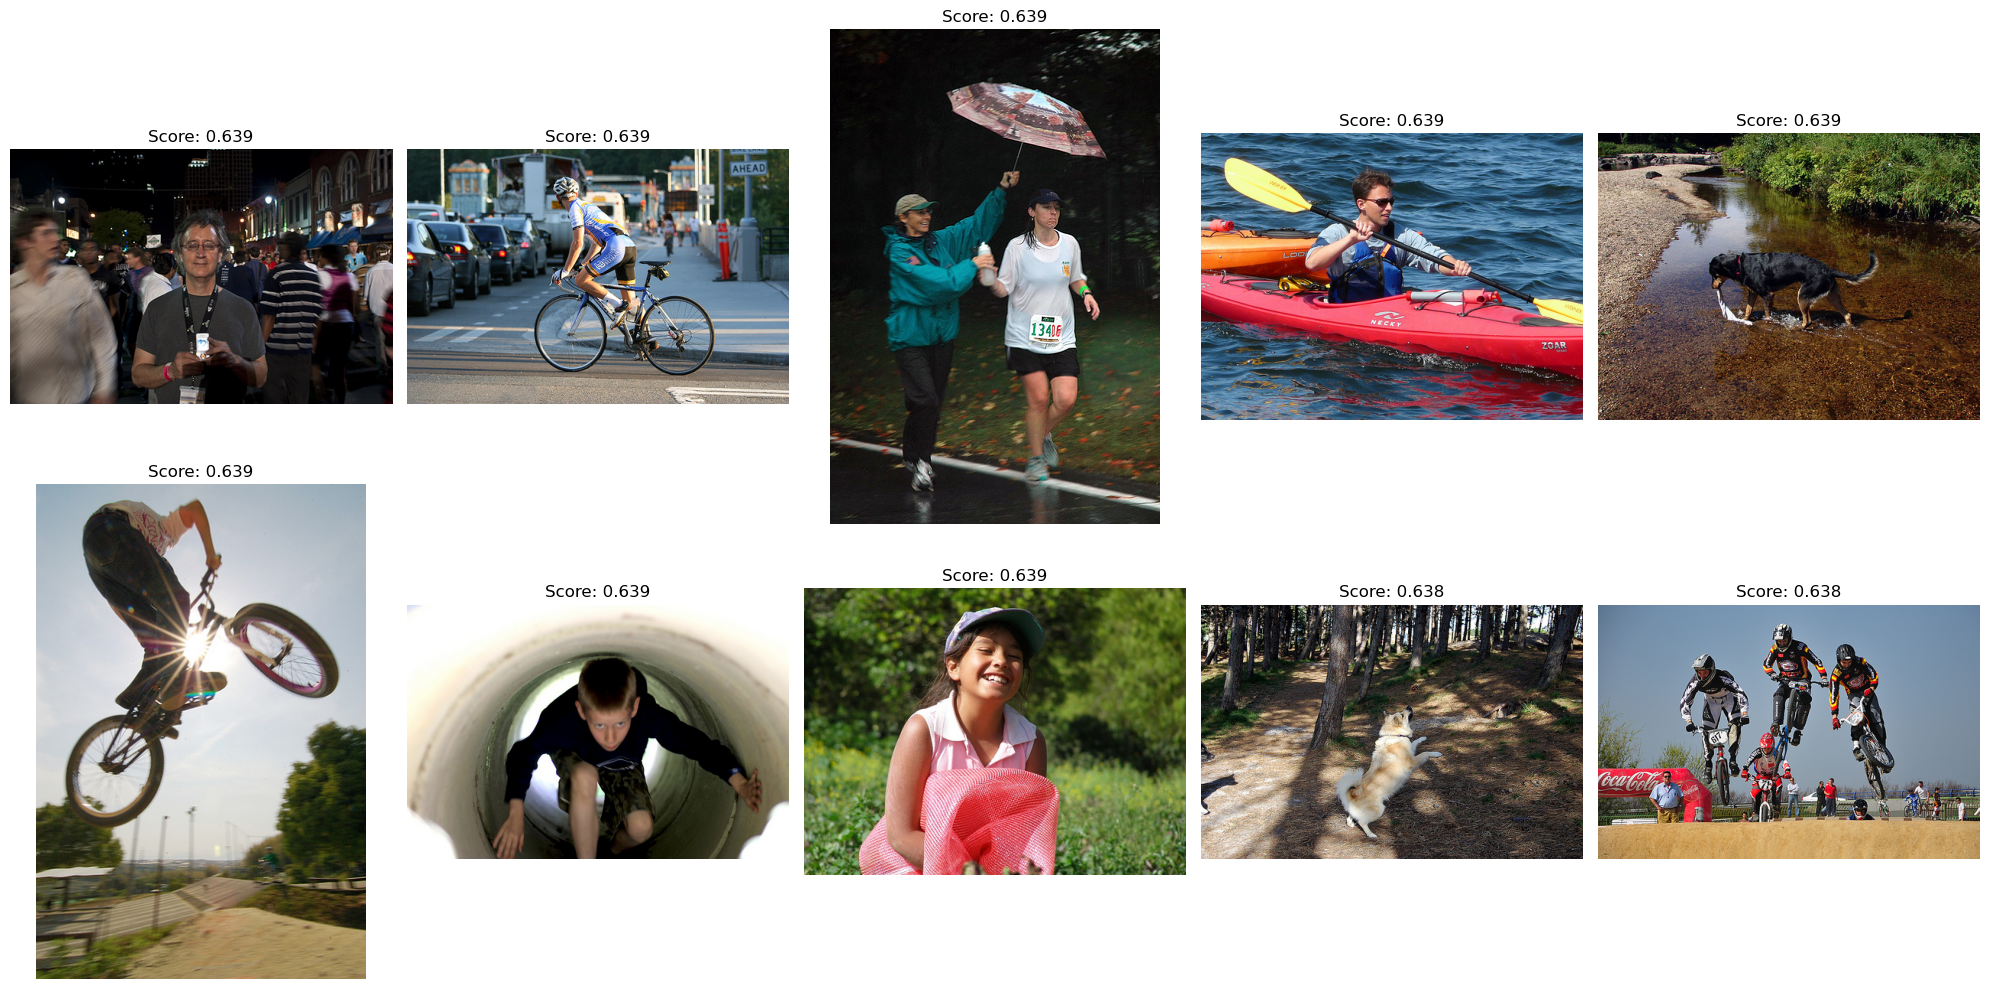

In [49]:
query = test['caption'].sample(1).values[0]
# query = 'two people wearing hats'
print(query)
fetch_similar(query, image_embeddings, train['image_path'].values)

In [12]:
test['image_path'].values.shape

(8091,)